In [1]:
import numpy as np
from scipy.linalg import block_diag

import pandas as pd
from pyproj import Transformer
import movingpandas as mpd

from kalman import KalmanFilter, UnscentedKalmanFilter

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import scienceplots
plt.style.use('science')
import seaborn as sns
import folium as fl

import time

# Differenced SOG, COG and Time Histograms

In [2]:
miami_data = pd.read_csv("../data/2_miami_voyages.csv")
france_data = pd.read_csv("../data/2_france_voyages.csv")

In [3]:
miami_data["BaseDateTime"] = pd.to_datetime(miami_data["BaseDateTime"])
miami_vars_diff = miami_data.groupby("voyage_id")[["SOG", "COG", "BaseDateTime"]].diff()
miami_vars_diff["BaseDateTime"] = miami_vars_diff["BaseDateTime"].dt.total_seconds() / 60

In [4]:
miami_vars_diff.describe()

,SOG,COG,BaseDateTime
count,1.129926e+06,1.129926e+06,1.129926e+06
mean,3.367654e-03,5.481474e-02,1.843078e+00
std,4.917362e-01,2.110725e+01,1.218772e+01
min,-3.610000e+01,-3.103000e+02,0.000000e+00
25%,0.000000e+00,-5.000000e-01,1.116667e+00
50%,0.000000e+00,0.000000e+00,1.183333e+00
75%,1.000000e-01,5.000000e-01,1.500000e+00
max,4.040000e+01,3.104000e+02,2.055967e+03


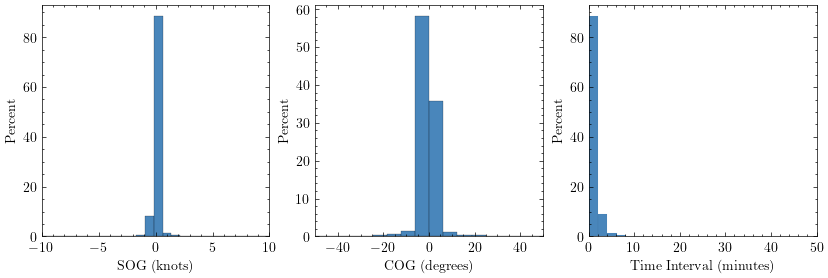

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
sns.histplot(data=miami_vars_diff, x="SOG", stat="percent", bins=100, ax=axs[0])
axs[0].set_xlim([-10, 10])
axs[0].set_xlabel("SOG (knots)")
sns.histplot(data=miami_vars_diff, x="COG", stat="percent", bins=100, ax=axs[1])
axs[1].set_xlim([-50, 50])
axs[1].set_xlabel("COG (degrees)")
sns.histplot(data=miami_vars_diff, x="BaseDateTime", stat="percent", bins=1000, ax=axs[2])
axs[2].set_xlim([0, 50])
axs[2].set_xlabel("Time Interval (minutes)")
plt.savefig("../figures/tese/metodos/miami_vars_diff_hist")
plt.show()

In [6]:
france_data["BaseDateTime"] = pd.to_datetime(france_data["BaseDateTime"])
france_vars_diff = france_data.groupby("voyage_id")[["SOG", "COG", "BaseDateTime"]].diff()
france_vars_diff["BaseDateTime"] = france_vars_diff["BaseDateTime"].dt.total_seconds() / 60

In [7]:
france_vars_diff.describe()

,SOG,COG,BaseDateTime
count,186310.000000,186310.000000,186310.000000
mean,0.000609,-0.056821,0.423859
std,0.421415,17.435271,17.681170
min,-11.900000,-359.800000,0.000000
25%,-0.100000,-1.000000,0.100000
50%,0.000000,0.000000,0.150000
75%,0.100000,1.000000,0.166667
max,8.900000,359.700000,2423.533333


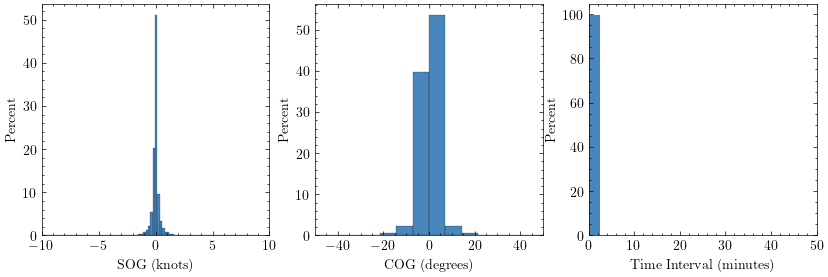

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
sns.histplot(data=france_vars_diff, x="SOG", stat="percent", bins=100, ax=axs[0])
axs[0].set_xlim([-10, 10])
axs[0].set_xlabel("SOG (knots)")
sns.histplot(data=france_vars_diff, x="COG", stat="percent", bins=100, ax=axs[1])
axs[1].set_xlim([-50, 50])
axs[1].set_xlabel("COG (degrees)")
sns.histplot(data=france_vars_diff, x="BaseDateTime", stat="percent", bins=1000, ax=axs[2])
axs[2].set_xlim([0, 50])
axs[2].set_xlabel("Time Interval (minutes)")
plt.savefig("../figures/tese/metodos/france_vars_diff_hist")
plt.show()

# Tests on trajectories

In [12]:
data = pd.read_csv("../data/2_miami_voyages.csv")

data = data[["voyage_id", "BaseDateTime", "x", "y", "SOG", "COG"]]

data["BaseDateTime"] = pd.to_datetime(data["BaseDateTime"])
data["SOG"] *= 0.5144444
data["COG"] *= np.pi / 180

data["vx"] = np.sin(data["COG"]) * data["SOG"]
data["vy"] = np.cos(data["COG"]) * data["SOG"]

data.drop(columns=["SOG", "COG"], inplace=True)

data.set_index(["voyage_id", "BaseDateTime"], inplace=True)

In [13]:
data.head()

x             y        vx        vy
voyage_id BaseDateTime                                                       
1-0       2021-02-18 19:49:02 -8.784490e+06  2.620494e+06 -6.941943  0.206032
          2021-02-18 19:53:46 -8.785441e+06  2.622489e+06 -6.886815  2.277596
          2021-02-18 20:00:45 -8.786643e+06  2.625578e+06 -6.910288  2.205354
          2021-02-18 20:03:22 -8.787106e+06  2.626712e+06 -6.776432  2.439666
          2021-02-18 20:05:10 -8.787429e+06  2.627499e+06 -6.883833  2.117744

In [14]:
data_resampled = data.groupby(level=0, sort=False)\
    .resample("2T", level=1).mean()

In [15]:
data_resampled.isna().sum()

x     284989
y     284989
vx    284989
vy    284989
dtype: int64

In [16]:
complete_voyages = data_resampled.groupby(level=0, sort=False, group_keys=False)\
    .apply(lambda x: x if x["x"].isna().sum() == 0 else None)

In [17]:
complete_voyages

x             y        vx        vy
voyage_id BaseDateTime                                                       
12-13     2020-11-20 03:42:00 -8.855421e+06  2.852593e+06 -5.192441  3.144654
          2020-11-20 03:44:00 -8.855499e+06  2.853124e+06 -5.164801  3.189846
          2020-11-20 03:46:00 -8.855601e+06  2.853916e+06 -4.863895  3.367921
          2020-11-20 03:48:00 -8.855679e+06  2.854507e+06 -4.907461  3.019090
          2020-11-20 03:50:00 -8.855789e+06  2.855384e+06 -5.042319  3.286832
...                                     ...           ...       ...       ...
261-1     2018-04-06 08:22:00 -8.870970e+06  2.942879e+06  1.538906 -6.665732
          2018-04-06 08:24:00 -8.870734e+06  2.941832e+06  1.590975 -6.627851
          2018-04-06 08:26:00 -8.870552e+06  2.941075e+06  1.770869 -6.608971
          2018-04-06 08:28:00 -8.870359e+06  2.940286e+06  1.486195 -6.704831
          2018-04-06 08:30:00 -8.870184e+06  2.939495e+06  1.655256 -6.638871

[7483 rows x 4 columns]

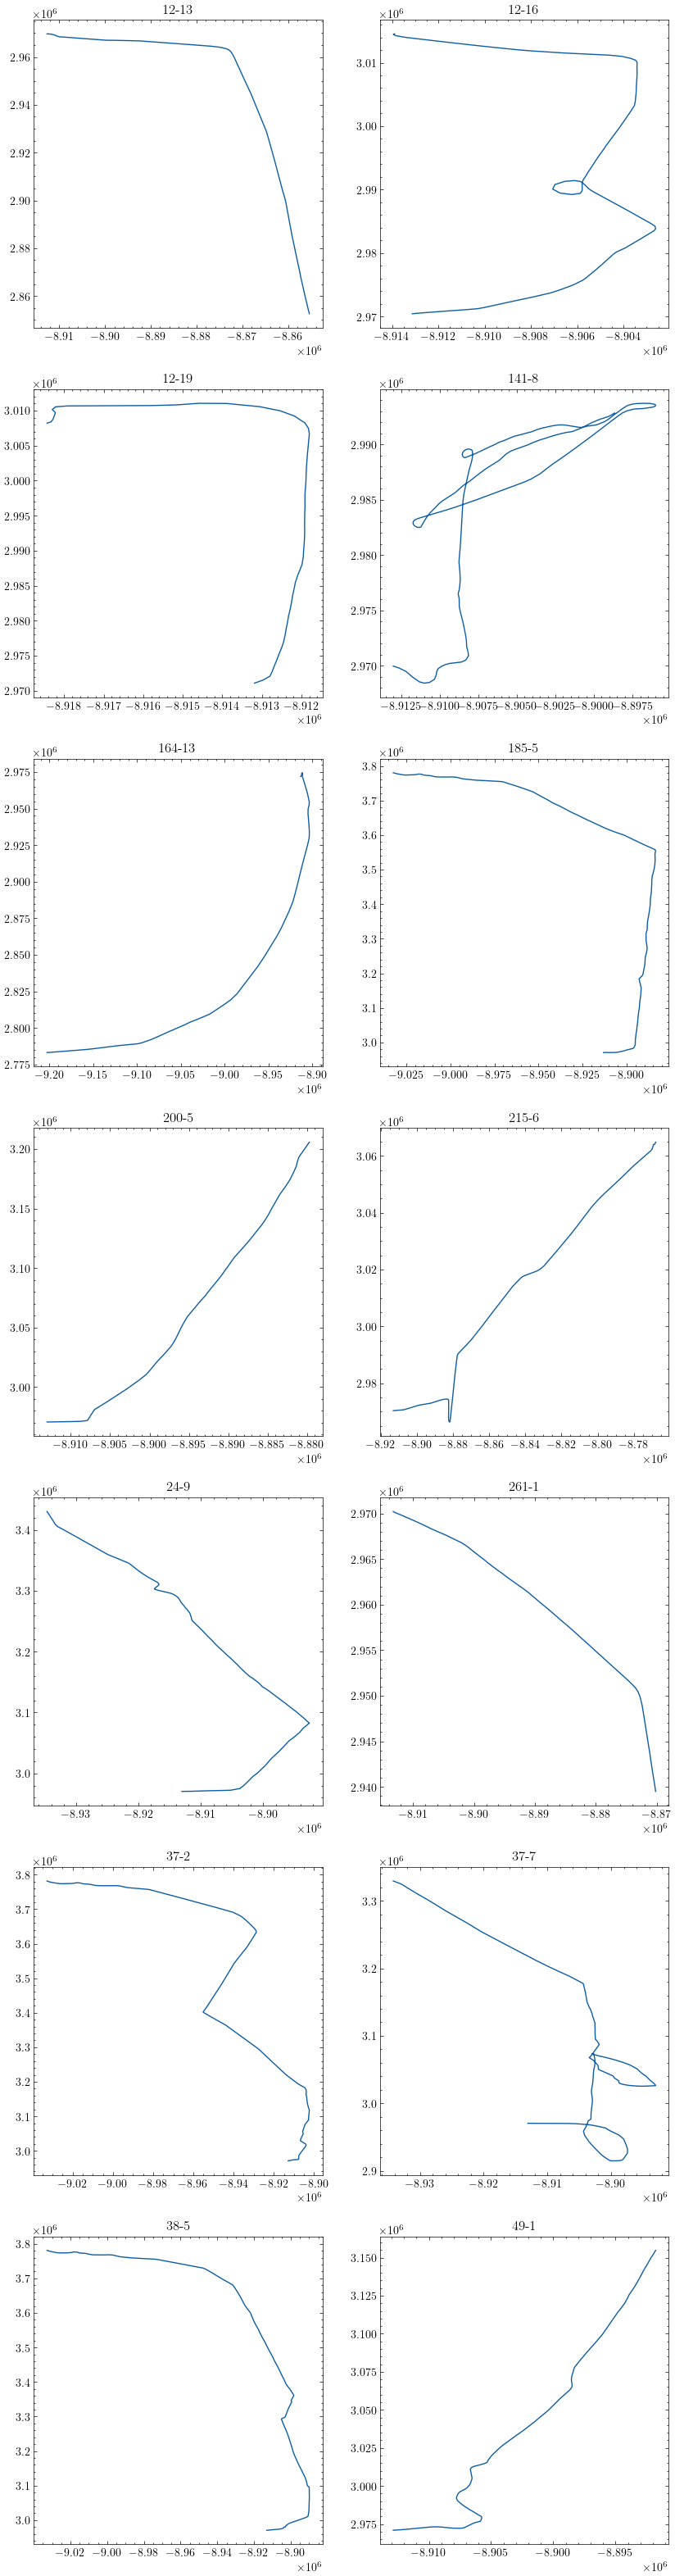

In [18]:
n = complete_voyages.index.unique(level="voyage_id").shape[0]

fig, ax = plt.subplots(nrows=int(np.ceil(n//2)), ncols=2, figsize=(10, 40))

i=0
for trajectory_id, trajectory in complete_voyages.groupby(level=0):
    ax[i//2][i%2].plot(trajectory["x"], trajectory["y"])
    ax[i//2][i%2].set_title(trajectory_id)
    i += 1

plt.savefig("../figures/tese/metodos/complete_voyages_appendix")
plt.show()

In [19]:
complete_voyages.sort_index(inplace=True)
sharpturn = complete_voyages.loc[("12-13",), ["x", "vx", "y", "vy"]]
curved = complete_voyages.loc[("164-13",), ["x", "vx", "y", "vy"]]
linear = complete_voyages.loc[("200-5",), ["x", "vx", "y", "vy"]]

In [20]:
print(sharpturn.iloc[0].name)
print(curved.iloc[0].name)
print(linear.iloc[0].name)

2020-11-20 03:42:00
2021-01-09 00:00:00
2020-12-25 00:00:00


In [21]:
def cv_model_2d(dt, accel, meas_noise):

    F = np.eye(4)
    F[0, 1] = F[2, 3] = dt
    H = np.zeros((2,4))
    H[0,0] = H[1,2] = 1

    block = np.array([[dt**4/4, dt**3/2],
                      [dt**3/2, dt**2]])
    Q = block_diag(block, block) * (accel**2)

    R = np.eye(2) * (meas_noise**2)
    P = np.eye(4) * 0.01

    return F, H, Q, R, P

In [22]:
def init_filters(x0, dt, accel, meas_noise_var):

    F, H, Q, R, P = cv_model_2d(dt, accel, meas_noise_var)

    kf = KalmanFilter(x0, F, None, H, Q, R, P)
    ukf = UnscentedKalmanFilter(x0, F, None, H, Q, R, P,
                                0.001, 2, 0)

    return kf, ukf

def test_filter(data, dt, accel, meas_noise, x0):

    kf, ukf = init_filters(x0, dt, accel, meas_noise)

    kf_residuals = []
    ukf_residuals = []
    kf_times = []
    ukf_times = []
    for z in data.iloc[1:, [0,2]].values:

        start = time.time()
        kf.predict()
        kf.update(z[:, np.newaxis])
        end = time.time()
        kf_times.append(end-start)
        kf_residuals.append(kf.y)

        start = time.time()
        ukf.predict()
        ukf.update(z[:, np.newaxis])
        end = time.time()
        ukf_times.append(end-start)
        ukf_residuals.append(ukf.y)

    kf_mae = np.mean(np.abs(kf_residuals), axis=0)
    ukf_mae = np.mean(np.abs(ukf_residuals), axis=0)

    kf_rmse = np.sqrt(np.mean(np.array(kf_residuals)**2, axis=0))
    ukf_rmse = np.sqrt(np.mean(np.array(ukf_residuals)**2, axis=0))

    kf_time = np.mean(kf_times)
    ukf_time = np.mean(ukf_times)

    return kf_mae, ukf_mae, kf_rmse, ukf_rmse, kf_time, ukf_time


def test_filters(data):

    dt = 120
    meas_noise = 10
    x0 = data.iloc[0].values[:, np.newaxis]
    accel_vals = np.logspace(-10, 0, 11)

    kf_mae_list = []
    ukf_mae_list = []
    kf_rmse_list = []
    ukf_rmse_list = []

    for accel in accel_vals:

        kf_mae, ukf_mae, kf_rmse, ukf_rmse, _, _ = test_filter(data, dt, accel, meas_noise, x0)
        kf_mae_list.append(kf_mae)
        ukf_mae_list.append(ukf_mae)
        kf_rmse_list.append(kf_rmse)
        ukf_rmse_list.append(ukf_rmse)

    return np.array(kf_mae_list).reshape((accel_vals.shape[0], 2)), \
        np.array(ukf_mae_list).reshape((accel_vals.shape[0], 2)), \
        np.array(kf_rmse_list).reshape((accel_vals.shape[0], 2)), \
        np.array(ukf_rmse_list).reshape((accel_vals.shape[0], 2))

In [23]:
def plot_results(xlabels, kf, ukf, measure, title, legend, ax):

    x = np.arange(kf.shape[0]) * 2
    width = 0.75

    ax.bar(x=x - width/2, height=kf[:, 0], width=width, label="KF (X)", color="tab:blue")
    markerline, stemlines, baseline = ax.stem(x - width/2, kf[:, 1], label="KF (Y)")
    plt.setp(baseline, alpha=0)
    plt.setp(stemlines, linewidth=2, path_effects=[pe.Stroke(linewidth=3.5, foreground="black"), pe.Normal()], color="tab:blue")
    plt.setp(markerline, markersize=5, markeredgecolor='black', markeredgewidth=.75, color="tab:blue")
    
    ax.bar(x=x + width/2, height=ukf[:, 0], width=width, label="UKF (X)", color="tab:orange")
    markerline, stemlines, baseline = ax.stem(x + width/2, ukf[:, 1], label="UKF (Y)")
    plt.setp(baseline, alpha=0)
    plt.setp(stemlines, linewidth=2, path_effects=[pe.Stroke(linewidth=3.5, foreground="black"), pe.Normal()], color="tab:orange")
    plt.setp(markerline, markersize=5, markeredgecolor='black', markeredgewidth=.75, color="tab:orange")

    xlabels = np.vectorize(np.format_float_scientific)(xlabels)

    ax.set_xticks(ticks=x, labels=xlabels, rotation=45)
    ax.set_xlabel("$Q(\sigma_a)$")

    if measure == "mae":
        ax.set_ylabel("$MAE (m)$")
    elif measure == "rmse":
        ax.set_ylabel("$RMSE (m)$")

    ax.set_title(title)

    if legend:
        ax.legend()

In [28]:
kf_mae_sharpturn, ukf_mae_sharpturn, kf_rmse_sharpturn, ukf_rmse_sharpturn = test_filters(sharpturn)
kf_mae_curved, ukf_mae_curved, kf_rmse_curved, ukf_rmse_curved = test_filters(curved)
kf_mae_linear, ukf_mae_linear, kf_rmse_linear, ukf_rmse_linear = test_filters(linear)

In [29]:
accel_vals = np.logspace(-10, 0, 11)

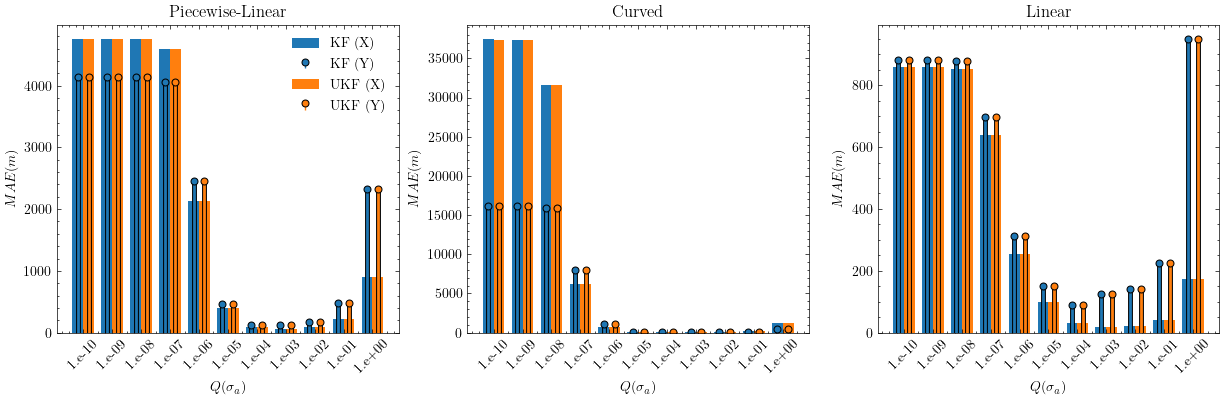

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
plot_results(accel_vals, kf_mae_sharpturn, ukf_mae_sharpturn, measure="mae", title="Piecewise-Linear", legend=True, ax=axs[0])
plot_results(accel_vals, kf_mae_curved, ukf_mae_curved, measure="mae", title="Curved", legend=False, ax=axs[1])
plot_results(accel_vals, kf_mae_linear, ukf_mae_linear, measure="mae", title="Linear", legend=False, ax=axs[2])
plt.savefig("../figures/tese/resultados/filling_missing_data/kf_tests_mae")
plt.show()

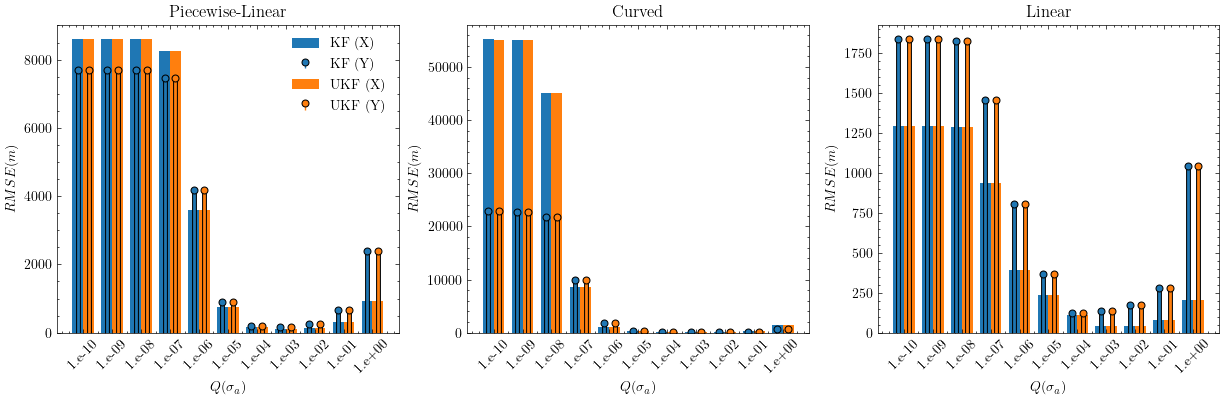

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
plot_results(accel_vals, kf_rmse_sharpturn, ukf_rmse_sharpturn, measure="rmse", title="Piecewise-Linear", legend=True, ax=axs[0])
plot_results(accel_vals, kf_rmse_curved, ukf_rmse_curved, measure="rmse", title="Curved", legend=False, ax=axs[1])
plot_results(accel_vals, kf_rmse_linear, ukf_rmse_linear, measure="rmse", title="Linear", legend=False, ax=axs[2])
plt.savefig("../figures/tese/resultados/filling_missing_data/kf_tests_rmse")
plt.show()

In [32]:
print(accel_vals[np.argmin(np.mean(kf_rmse_sharpturn, axis=1))])
print(accel_vals[np.argmin(np.mean(kf_rmse_curved, axis=1))])
print(accel_vals[np.argmin(np.mean(kf_rmse_linear, axis=1))])

0.001
0.001
0.001


In [33]:
print(accel_vals[np.argmin(np.mean(kf_mae_sharpturn, axis=1))])
print(accel_vals[np.argmin(np.mean(kf_mae_curved, axis=1))])
print(accel_vals[np.argmin(np.mean(kf_mae_linear, axis=1))])

0.001
0.0001
0.0001


In [24]:
kf_mae, ukf_mae, kf_rmse, ukf_rmse, kf_time, ukf_time = test_filter(accel=0.001,
                                                                    data=sharpturn,
                                                                    dt=120,
                                                                    meas_noise=10,
                                                                    x0=sharpturn.iloc[0].values[:, np.newaxis])

In [25]:
print(kf_mae)
print(ukf_mae)
print(kf_rmse)
print(ukf_rmse)
print(kf_time)
print(ukf_time)

[[ 60.63581952]
 [121.68353981]]
[[ 60.63582503]
 [121.68353895]]
[[ 98.83268324]
 [156.93513827]]
[[ 98.83251634]
 [156.93511943]]
4.767211707862648e-05
0.000838636707615208


In [26]:
kf_mae, ukf_mae, kf_rmse, ukf_rmse, kf_time, ukf_time = test_filter(accel=0.001,
                                                                    data=curved,
                                                                    dt=120,
                                                                    meas_noise=10,
                                                                    x0=curved.iloc[0].values[:, np.newaxis])

In [27]:
print(kf_mae)
print(ukf_mae)
print(kf_rmse)
print(ukf_rmse)
print(kf_time)
print(ukf_time)

[[67.26340219]
 [44.91974714]]
[[67.26342564]
 [44.91974499]]
[[93.1722644 ]
 [65.84912739]]
[[93.17226032]
 [65.84913278]]
3.840061522671951e-05
0.0007380667135136429


In [34]:
kf_mae, ukf_mae, kf_rmse, ukf_rmse, kf_time, ukf_time = test_filter(accel=0.001,
                                                                    data=linear,
                                                                    dt=120,
                                                                    meas_noise=10,
                                                                    x0=linear.iloc[0].values[:, np.newaxis])

In [35]:
print(kf_mae)
print(ukf_mae)
print(kf_rmse)
print(ukf_rmse)
print(kf_time)
print(ukf_time)

[[ 19.79235687]
 [124.31467157]]
[[ 19.7923218 ]
 [124.31465641]]
[[ 39.57629831]
 [134.98370914]]
[[ 39.57627921]
 [134.98370036]]
4.185425056206001e-05
0.0008037306450225495


# Tested Trajectories Plots

In [38]:
transformer = Transformer.from_crs(crs_from=3857, crs_to=4326)
lat, lon = transformer.transform(xx=sharpturn["x"].to_numpy(),
                                 yy=sharpturn["y"].to_numpy())
sharpturn["LAT"] = lat
sharpturn["LON"] = lon

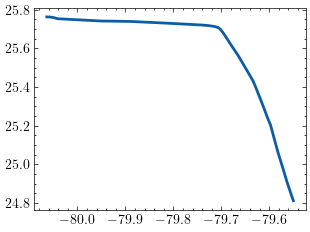

In [39]:
plt.figure()
plt.plot(lon, lat, linewidth=2)
plt.show()

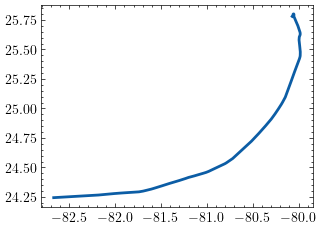

In [40]:
lat, lon = transformer.transform(xx=curved["x"].to_numpy(),
                                 yy=curved["y"].to_numpy())
curved["LAT"] = lat
curved["LON"] = lon

plt.figure()
plt.plot(lon, lat, linewidth=2)
plt.show()

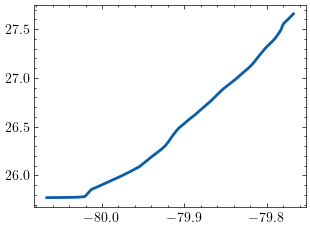

In [41]:
lat, lon = transformer.transform(xx=linear["x"].to_numpy(),
                                 yy=linear["y"].to_numpy())
linear["LAT"] = lat
linear["LON"] = lon

plt.figure()
plt.plot(lon, lat, linewidth=2)
plt.show()

In [42]:
def plot_vessel_voyages(vessel_data, colors):

    trajectories = mpd.TrajectoryCollection(data=vessel_data,
                                            traj_id_col="voyage_id",
                                            t="BaseDateTime",
                                            x="LON", y="LAT", crs="epsg:4326")

    m = fl.Map(width=500, height=500, location=[25.7, -80.1], zoom_start=5)

    i = 0
    for trajectory in trajectories.trajectories:
        coords = [[x[1], x[0]] for x in trajectory.to_linestring().coords]
        fl.PolyLine(coords, color=colors[i], weight=2, opacity=1, popup=trajectory.id).add_to(m)
        i+=1

    return m

In [43]:
voyages_data = data_resampled.loc[data_resampled.index.get_level_values("voyage_id").isin(["12-13", "164-13", "200-5"])]

transformer = Transformer.from_crs(crs_from=3857, crs_to=4326)
lat, lon = transformer.transform(xx=voyages_data["x"].to_numpy(),
                                 yy=voyages_data["y"].to_numpy())
voyages_data = voyages_data.assign(LAT=lat, LON=lon)
voyages_data.reset_index(inplace=True)

In [44]:
plot_vessel_voyages(voyages_data, ["red", "green", "blue"])

# Test on the whole Miami and Brest datasets

In [36]:
miami_data = pd.read_csv("../data/2_miami_voyages.csv")

miami_data = miami_data[["voyage_id", "BaseDateTime", "x", "y", "SOG", "COG"]]

miami_data["BaseDateTime"] = pd.to_datetime(miami_data["BaseDateTime"])
miami_data["SOG"] *= 0.5144444
miami_data["COG"] *= np.pi / 180

miami_data["vx"] = np.sin(miami_data["COG"]) * miami_data["SOG"]
miami_data["vy"] = np.cos(miami_data["COG"]) * miami_data["SOG"]

miami_data.drop(columns=["SOG", "COG"], inplace=True)

miami_data.set_index(["voyage_id", "BaseDateTime"], inplace=True)

france_data = pd.read_csv("../data/2_france_voyages.csv")

france_data = france_data[["voyage_id", "BaseDateTime", "x", "y", "SOG", "COG"]]

france_data["BaseDateTime"] = pd.to_datetime(france_data["BaseDateTime"])
france_data["SOG"] *= 0.5144444
france_data["COG"] *= np.pi / 180

france_data["vx"] = np.sin(france_data["COG"]) * france_data["SOG"]
france_data["vy"] = np.cos(france_data["COG"]) * france_data["SOG"]

france_data.drop(columns=["SOG", "COG"], inplace=True)

france_data.set_index(["voyage_id", "BaseDateTime"], inplace=True)

In [37]:
def cv_model_2d(dt, accel, meas_noise):

    F = np.eye(4)
    F[0, 1] = F[2, 3] = dt
    H = np.zeros((2,4))
    H[0,0] = H[1,2] = 1

    block = np.array([[dt**4/4, dt**3/2],
                      [dt**3/2, dt**2]])
    Q = block_diag(block, block) * (accel**2)

    R = np.eye(2) * (meas_noise ** 2)
    P = np.eye(4) * 0.01

    return F, H, Q, R, P

def extrapolate_voyage(voyage_data, filter_type="kf"):

    # Get KF measures and AIS messages in different arrays
    kf_measures = voyage_data[["x", "vx", "y", "vy"]].values

    # Initialize Kalman Filter
    F, H, Q, R, P = cv_model_2d(120, 0.001, 10)
    x0 = kf_measures[0, :, np.newaxis]

    if filter_type == "kf":
        kf = KalmanFilter(x0, F, None, H, Q, R, P)
    else:
        kf = UnscentedKalmanFilter(x0, F, None, H, Q, R, P, 0.001, 2, 0)

    # Save P for reset
    P = kf.P

    # Variables
    reset = False
    extrapolated_voyage = np.zeros(shape=(voyage_data.shape[0], 2)) # array of predictions

    # filter the voyage data
    time_exec_arr = np.zeros(kf_measures.shape[0] - 1)
    for i in range(1, kf_measures.shape[0]):

        if np.isnan(kf_measures[i,0]):
            reset = True
            continue

        if reset:
            kf.x = kf_measures[i, :, np.newaxis]
            kf.P = P      

        start = time.time()
        kf.predict()
        extrapolated_voyage[i] = kf.x[[0, 2], 0]
        kf.update(kf_measures[i, [0, 2], np.newaxis])
        time_exec_arr[i-1] = time.time() - start
    
    time_exec = np.mean(time_exec_arr)
    mae_x = np.mean(np.abs(extrapolated_voyage[1:, 0] - kf_measures[1:, 0]))
    mae_y = np.mean(np.abs(extrapolated_voyage[1:, 1] - kf_measures[1:, 2]))
    rmse_x = np.sqrt(np.mean((extrapolated_voyage[1:, 0] - kf_measures[1:, 0])**2))
    rmse_y = np.sqrt(np.mean((extrapolated_voyage[1:, 1] - kf_measures[1:, 2])**2))

    return np.array([time_exec, mae_x, mae_y, rmse_x, rmse_y])

In [38]:
miami_results_kf = miami_data.groupby("voyage_id").apply(lambda x: extrapolate_voyage(x, "kf"))
miami_results_ukf = miami_data.groupby("voyage_id").apply(lambda x: extrapolate_voyage(x, "ukf"))

In [39]:
france_results_kf = france_data.groupby("voyage_id").apply(lambda x: extrapolate_voyage(x, "kf"))
france_results_ukf = france_data.groupby("voyage_id").apply(lambda x: extrapolate_voyage(x, "ukf"))

In [40]:
miami_results_kf = np.vstack(miami_results_kf)
miami_results_ukf = np.vstack(miami_results_ukf)
france_results_kf = np.vstack(france_results_kf)
france_results_ukf = np.vstack(france_results_ukf)

In [41]:
miami_results_kf_mean = np.mean(miami_results_kf, axis=0)
miami_results_ukf_mean = np.mean(miami_results_ukf, axis=0)
france_results_kf_mean = np.mean(france_results_kf, axis=0)
france_results_ukf_mean = np.mean(france_results_ukf, axis=0)

In [42]:
print(miami_results_kf_mean)
print(miami_results_ukf_mean)
print(france_results_kf_mean)
print(france_results_ukf_mean)

[3.68982500e-05 3.38059900e+02 4.55498221e+02 2.43668814e+03
 3.17908507e+03]
[6.98161282e-04 3.38059900e+02 4.55498221e+02 2.43668813e+03
 3.17908507e+03]
[3.94443667e-05 9.26348955e+01 8.02282536e+01 8.19744134e+02
 6.88978606e+02]
[6.85995026e-04 9.26348956e+01 8.02282520e+01 8.19744134e+02
 6.88978605e+02]


In [43]:
results_df = pd.DataFrame(
    data=np.vstack(
        (
            miami_results_kf_mean[1:],
            miami_results_ukf_mean[1:],
            france_results_kf_mean[1:],
            france_results_ukf_mean[1:],
        )
    ),
    columns=["MAE-X", "MAE-Y", "RMSE-X", "RMSE-Y"],
    index=pd.MultiIndex.from_tuples(
        [("Miami", "KF"), ("Miami", "UKF"), ("France", "KF"), ("France", "UKF")]
    ),
)

In [44]:
print(results_df.style.to_latex())

\begin{tabular}{llrrrr}
 &  & MAE-X & MAE-Y & RMSE-X & RMSE-Y \\
\multirow[c]{2}{*}{Miami} & KF & 338.059900 & 455.498221 & 2436.688141 & 3179.085074 \\
 & UKF & 338.059900 & 455.498221 & 2436.688132 & 3179.085074 \\
\multirow[c]{2}{*}{France} & KF & 92.634896 & 80.228254 & 819.744134 & 688.978606 \\
 & UKF & 92.634896 & 80.228252 & 819.744134 & 688.978605 \\
\end{tabular}



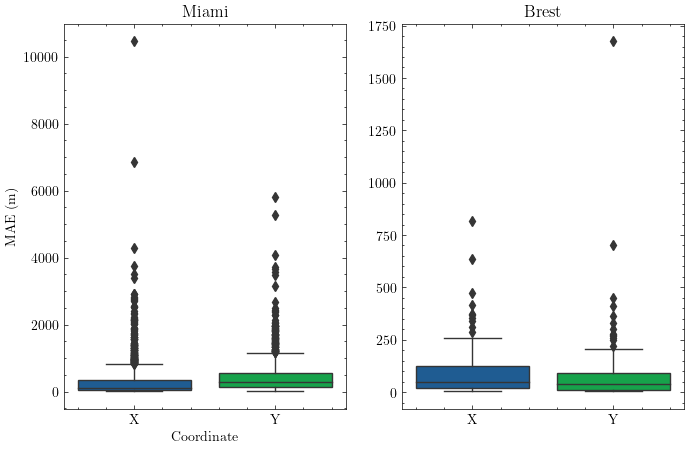

In [48]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
sns.boxplot(data=miami_results_kf[:, [1,2]], ax=axs[0])
axs[0].set_xticks([0, 1], ["X", "Y"])
axs[0].set_ylabel("MAE (m)")
axs[0].set_xlabel("Coordinate")
axs[0].set_title("Miami")
sns.boxplot(data=france_results_kf[:, [1,2]], ax=axs[1])
axs[1].set_xticks([0, 1], ["X", "Y"])
axs[1].set_title("Brest")
plt.savefig("../figures/tese/resultados/filling_missing_data/kf_results_boxplots")
plt.show()